In [1]:
import os
from pprint import pprint
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from datetime import datetime
import re
from tqdm.auto import tqdm
import pandas as pd

### Подготавливаем для работы с API

In [2]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly",
          'https://www.googleapis.com/auth/youtube.force-ssl']

In [6]:
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret.json"
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=91469507607-tkrdmc3t2oqhk0q35lnm4rkf7a38btq6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=Pg7ufVn29qYjepY7uwvILMQj7LCC0K&prompt=consent&access_type=offline
Enter the authorization code: 4/4gGaJRTPBv4yCpDiwmu7BsooBWXx1lQ5bkVz88aflFi-8cTDxRiorfk


### Будем скачивать информации о видео How to basic

In [13]:
request = youtube.channels().list(  
    part="contentDetails",
    id="UCR4s1DE9J4DHzZYXMltSMAg",
)
response = request.execute()

In [15]:
playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [19]:
videos = []
page = 'CDIQAQ'
while len(videos) < 250:
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=playlist_id,
        maxResults=50,
        pageToken=page
    )
    response = request.execute()
    page = response['nextPageToken']

    for item in response['items']:
        content = item['contentDetails']
        videos.append({'id':content['videoId'],'date': content['videoPublishedAt']})

In [107]:
for video in tqdm(videos):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=video['id']
    )
    response = request.execute()['items'][0]

    content = response['contentDetails']
    snippet = response['snippet']
    stats = response['statistics']

    video['duration'] = content.get('duration')
    video['tags'] = snippet.get('tags')
    video['likes'] = int(stats.get('likeCount'))
    video['dislikes'] = int(stats.get('dislikeCount'))
    video['comments'] = int(stats.get('commentCount'))

### Заливаем в датафрейм и чистим данные

In [108]:
videos_df = pd.DataFrame(videos)

In [109]:
tags_df = videos_df[['id','tags']].explode('tags')

In [110]:
videos_df.drop(columns='tags', inplace=True)

In [111]:
tags_df.head()

,id,tags
0,yIFfZN65jig,how to make the travis scott burger
0,yIFfZN65jig,travis scott burger
0,yIFfZN65jig,mcdonald's travis scott burger
0,yIFfZN65jig,mcdonald's recipe
0,yIFfZN65jig,mcdonald's secret recipe


In [112]:
def to_sec(yttime):
    result = re.search(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?$', yttime).groups(0)
    hour, min, sec = list(map(int, result))
    return hour*3600 + min*60 + sec

In [113]:
videos_df['duration_s'] = videos_df.duration.apply(to_sec)

In [114]:
videos_df['date'] = pd.to_datetime(videos_df['date'])

In [115]:
videos_df.head()

,id,date,likes,dislikes,comments,duration,duration_s
0,yIFfZN65jig,2020-09-22 18:30:03+00:00,102545,4921,10391,PT3M34S,214
1,4X6NVHULExc,2020-09-19 18:36:01+00:00,65802,4872,8150,PT3M8S,188
2,lG3PEdw0xrU,2020-09-08 18:31:54+00:00,80203,6015,11869,PT2M46S,166
3,TPFvURCv-YE,2020-08-31 18:30:01+00:00,118139,4718,9581,PT1M40S,100
4,wNQx34RQZtI,2020-08-27 18:31:31+00:00,93656,4019,11918,PT4M1S,241


### Кладем все в базу данных

In [90]:
import sqlite3

In [30]:
con = sqlite3.connect('videos.db')
c = con.cursor()

In [31]:
import pandas.io.sql as pd_sql

In [116]:
pd_sql.to_sql(videos_df, "videos", con, index=False, if_exists='replace')
pd_sql.to_sql(tags_df, "tags", con, index=False, if_exists='replace')

In [117]:
con.commit()

### Рисуем графики

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


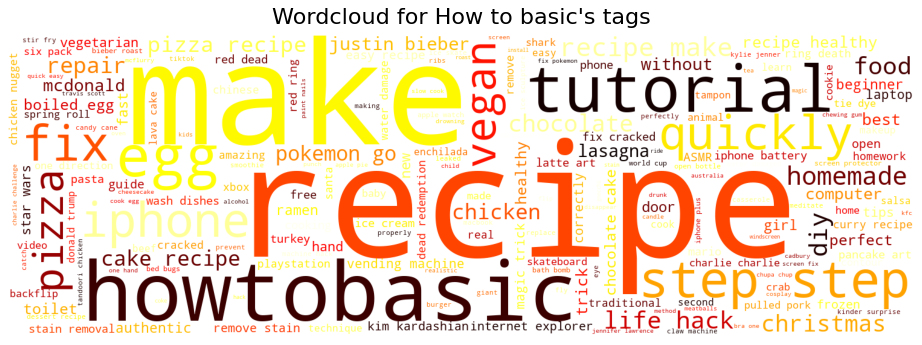

In [100]:
text = ' '.join(tags_df.tags.tolist())

wordcloud = WordCloud(
    background_color ='white',
    width = 1500,
    height = 500, 
    colormap='hot'
).generate(text)

plt.figure(figsize = (15, 5), dpi=80) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title("Wordcloud for How to basic's tags", fontsize=20, pad=10)
plt.show()

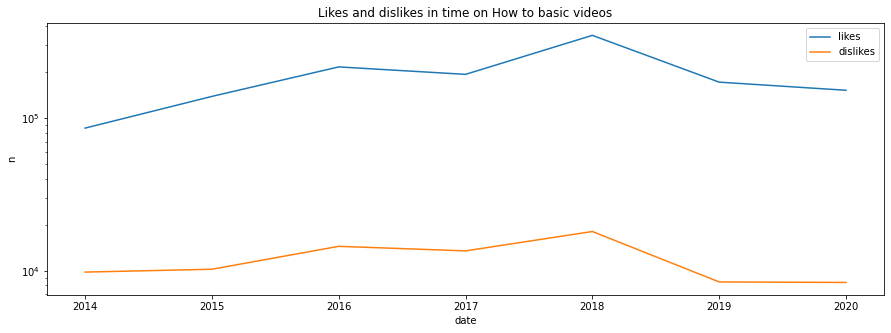

In [135]:
plt.figure(figsize=(15,5))
videos_df.groupby(videos_df.date.dt.year).likes.mean().plot()
videos_df.groupby(videos_df.date.dt.year).dislikes.mean().plot()
plt.legend()
plt.title('Likes and dislikes in time on How to basic videos')
plt.ylabel('n')
plt.yscale('log')

Text(0, 0.5, 'duartion in s')

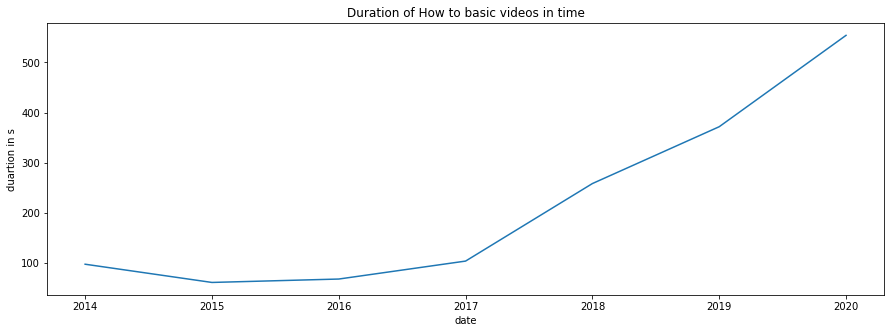

In [136]:
plt.figure(figsize=(15,5))
videos_df.groupby(videos_df.date.dt.year).duration_s.mean().plot()
plt.title('Duration of How to basic videos in time')
plt.ylabel('duartion in s')

### Языковой анализ

In [149]:
page = ''
comments = []
while len(comments) < 1000:
    request = youtube.commentThreads().list(
        part="snippet",
        videoId="Rj8bxm0fERw",
        maxResults=100,
        pageToken = page
    )
    response = request.execute()
    items = response['items']
    page = response['nextPageToken']
    for item in items:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            item['id'],
            comment['authorChannelId'].get('value'),
            comment.get('publishedAt'),
            comment.get('likeCount'),
            comment.get('textOriginal')
        ])

### Загружаем в датафрейм и определяем язык


In [151]:
comments_df = pd.DataFrame(comments, columns=['id','author_id','date','likes','text'])

In [154]:
comments_df.date = pd.to_datetime(comments_df.date)

In [ ]:
!pip install langdetect
from langdetect import detect

In [165]:
def detect_lang(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [166]:
comments_df['lang'] = comments_df.text.apply(detect_lang)

In [172]:
from string import punctuation
nltk.download('punkt')
import nltk

def preprocess(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [word for word in tokens if word != " " \
              and word.strip() not in punctuation]
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [173]:
comments_df['len'] = comments_df.text.apply(lambda x: len(preprocess(x)))

### Загружаем в базу данных

In [225]:
pd_sql.to_sql(comments_df, "comments", con, index=False, if_exists='replace')
con.commit()
con.close()

### Визуализируем

Text(0.5, 1.0, 'Length of comment in different languages')

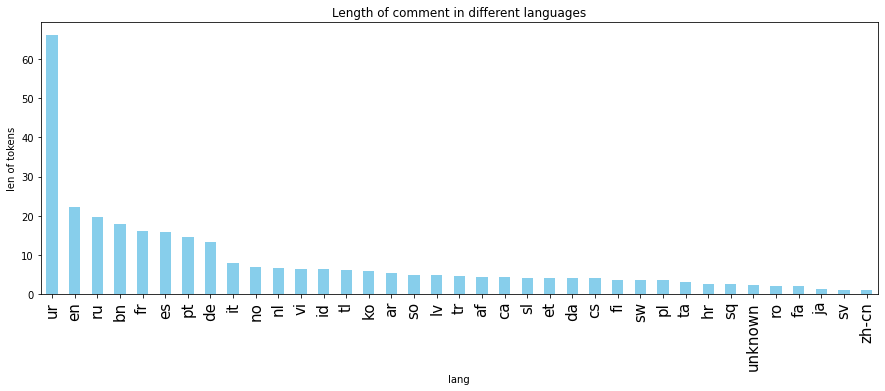

In [224]:
plt.figure(figsize=(15,5))
comments_df.groupby('lang').len.mean().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.xticks(fontsize=15)
plt.ylabel('len of tokens')
plt.title('Length of comment in different languages')

Text(0.5, 1.0, 'Number of coments in different languages')

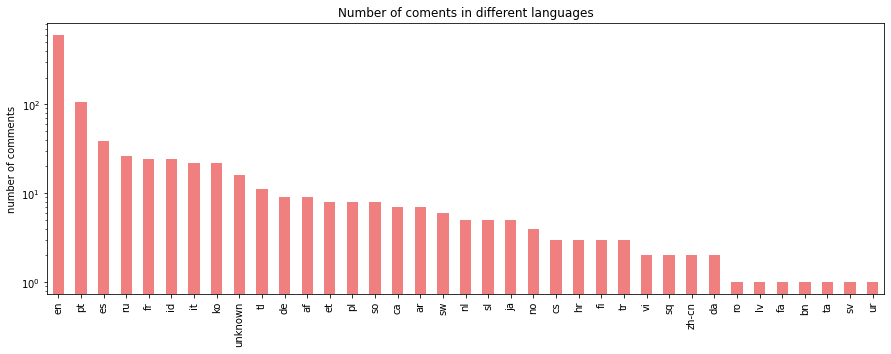

In [220]:
plt.figure(figsize=(15,5))
comments_df.lang.value_counts().plot(kind='bar', color='lightcoral')
plt.ylabel('number of comments')
plt.yscale('log')
plt.title('Number of coments in different languages')